## V9_Infra_Score_LightGBM_kfold5

In [24]:
import os, sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# path 설정
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath("")))))
print(sys.path[-1])

d:\base\boostcamp\apart\level2-competitiveds-recsys-06


In [25]:
raw_path: str = "../../../data/raw"
processed_path: str = "../../../data/processed"
submission_path: str = "../../../data/submission"

In [26]:
v9: pd.DataFrame = pd.read_csv(os.path.join(processed_path,"v9.csv"))

In [27]:
v9.columns

Index(['index', '_type', 'contract_year_month', 'contract_day', 'area_m2',
       'contract_date_numeric', 'floor', 'built_year', 'latitude', 'longitude',
       'age', 'contract_0', 'contract_1', 'deposit', 'apt_idx', 'area',
       'grid_deposit', 'apt_deposit_rank', 'apt_area_deposit_rank',
       'recent_deposit', 'interest_rate', 'grid_id', 'nearest_park_distance',
       'nearest_park_idx', 'park_grid_id', 'park_area',
       'nearest_school_distance', 'nearest_school_idx', 'school_grid_id',
       'nearest_subway_distance', 'nearest_subway_idx', 'subway_grid_id',
       'park_count', 'school_count', 'subway_count', 'date_length',
       'contract_date', 'contract_timestamp'],
      dtype='object')

In [28]:
# v8: pd.DataFrame = pd.read_csv(os.path.join(processed_path,"V8+subway_1.csv"))
# # v8의 subway_1 컬럼을 v9에 추가
# v9_sub1 = v9.merge(v8[['index', '_type', 'subway_1']], on=['index', '_type'], how='left')

# # 결과 확인
# v9.head()

### 컬럼 정리

In [29]:
columns = ['index','_type',
    'contract_date_numeric', 
    'area_m2',
    'floor', 'built_year', 'latitude', 'longitude','age', 
    'contract_0', 'contract_1', 
    'deposit', 
    'apt_idx', 
    'area',
    'grid_deposit', 
    'apt_deposit_rank', 'apt_area_deposit_rank',
    'recent_deposit', 
    'nearest_park_distance','nearest_park_idx', 'park_area',
    'nearest_school_distance', 'nearest_school_idx',
    'nearest_subway_distance', 'nearest_subway_idx',
    'park_count', 'school_count', 'subway_count',]
df = v9.filter(items=columns)


temp_train_df = df[df["_type"]=='train']
test_df = df[df["_type"]=='test']

## K-Fold CV(k=5) 적용 LightGBM

In [30]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 학습에 사용할 특징 열
feature_columns = [col for col in temp_train_df.columns if col not in ['deposit', '_type', 'index']]

# 학습 데이터 준비
X = temp_train_df[feature_columns]
y = temp_train_df['deposit']


# LightGBM 파라미터 설정
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42,
    'early_stopping_round' : 2500
}

# 콜백 함수 정의
def print_evaluation(period=10):
    def callback(env):
        if (env.iteration + 1) % period == 0:
            train_mae = env.evaluation_result_list[0][2]
            val_mae = env.evaluation_result_list[1][2]
            print(f"[{env.iteration + 1}] Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}")
    return callback

# 5-fold 교차 검증 설정
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# 각 폴드의 예측 결과를 저장할 리스트
oof_predictions = np.zeros(len(X))
test_predictions = np.zeros(len(test_df))

# 교차 검증 수행
for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    print(f"\nFold {fold}")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)
    
    model = lgb.train(
        params, 
        dtrain, 
        num_boost_round=12000, 
        valid_sets=[dtrain, dval], 
        callbacks=[print_evaluation(period=100)],
    )
    
    # 검증 세트에 대한 예측
    oof_predictions[val_idx] = model.predict(X_val)
    
    # 테스트 세트에 대한 예측
    test_predictions += model.predict(test_df[feature_columns]) / n_folds

# 전체 검증 세트에 대한 MAE 계산
oof_mae = mean_absolute_error(y, oof_predictions)
print(f"\nOverall OOF MAE: {oof_mae:.4f}")

# 테스트 세트에 대한 최종 예측 결과
y_pred = test_predictions

print("\nTraining completed.")


Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4578
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 25
[LightGBM] [Info] Start training from score 38183.560818
Training until validation scores don't improve for 2500 rounds
[100] Train MAE: 4128.5188, Val MAE: 4122.2279
[200] Train MAE: 4009.2537, Val MAE: 4012.5271
[300] Train MAE: 3965.1309, Val MAE: 3975.0463
[400] Train MAE: 3934.9666, Val MAE: 3950.2641
[500] Train MAE: 3911.1952, Val MAE: 3931.5157
[600] Train MAE: 3890.0287, Val MAE: 3915.8650
[700] Train MAE: 3873.3914, Val MAE: 3904.3692
[800] Train MAE: 3856.8123, Val MAE: 3892.8598
[900] Train MAE: 3842.9418, Val MAE: 3883.4425
[1000] Train MAE: 3832.1715, Val MAE: 3877.8564
[1100] Train MAE: 3821.3197, Val MAE: 3871.134

### Feature Importance

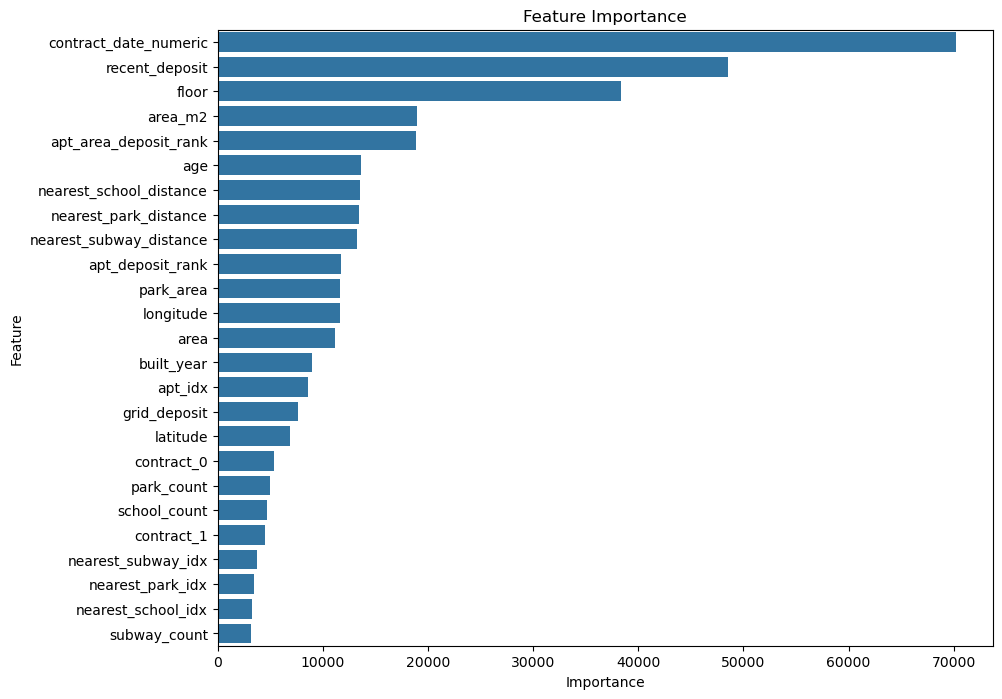

In [31]:
# LightGBM 모델의 피처 중요도 추출
feature_importance = model.feature_importance()

# 피처 중요도를 DataFrame으로 변환
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importance
})

# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

In [32]:
y_pred

array([22227.20653309,  7436.84501223,  5626.67964079, ...,
       44893.98449869, 38155.35789667, 38829.65665788])

In [33]:
# Create a DataFrame from y_pred with the same index as X_test
y_pred_df = pd.DataFrame(y_pred, index=range(len(y_pred)), columns=['deposit'])

# Display the DataFrame
y_pred_df.index.name = 'index'
y_pred_df

,deposit
index,
0,22227.206533
1,7436.845012
2,5626.679641
3,6024.912867
4,5961.391642
...,...
150167,37961.209316
150168,43537.915673
150169,44893.984499


In [34]:
y_pred_df['deposit'].mean()

np.float64(39146.54162998825)

In [35]:
y_pred_df.to_csv(os.path.join(submission_path, "V9_lightGBM_Kfold5_12000훈련.csv"), index=True)